In [40]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.utils as utils
import torchvision.transforms as transforms

from torch.utils.tensorboard import SummaryWriter

from attn_vgg import AttnVGG

In [131]:
def visualize_attn_sigmoid(I, c, up_factor, nrow):
    # image
    img = I.permute((1,2,0)).cpu().numpy()
    # compute the heatmap
    a = torch.sigmoid(c)
    if up_factor > 1:
        a = F.interpolate(a, scale_factor=up_factor, mode='bilinear', align_corners=False)
    attn = utils.make_grid(a, nrow=nrow, normalize=False)
    attn = attn.permute((1,2,0)).mul(255).byte().cpu().numpy()
    attn = cv2.applyColorMap(attn, cv2.COLORMAP_JET)
    attn = cv2.cvtColor(attn, cv2.COLOR_BGR2RGB)
    attn = np.float32(attn) / 255
    # add the heatmap to the image
    vis = 0.6 * img + 0.4 * attn
    return torch.from_numpy(vis).permute(2,0,1)

def visualize_attn_softmax(I, c, up_factor, nrow):
    # image
    img = I.permute((1,2,0)).cpu().numpy()
    # compute the heatmap
    N,C,W,H = c.size()
    a = F.softmax(c.view(N,C,-1), dim=2).view(N,C,W,H)
    if up_factor > 1:
        a = F.interpolate(a, scale_factor=up_factor, mode='bilinear', align_corners=False)
    attn = utils.make_grid(a, nrow=nrow, normalize=True, scale_each=True)
    attn = attn.permute((1,2,0)).mul(255).byte().cpu().numpy()
    attn = cv2.applyColorMap(attn, cv2.COLORMAP_JET)
    attn = cv2.cvtColor(attn, cv2.COLOR_BGR2RGB)
    attn = np.float32(attn) / 255
    # add the heatmap to the image
    vis = 0.6 * img + 0.4 * attn
    return torch.from_numpy(vis).permute(2,0,1)

In [6]:
writer = SummaryWriter('./runs/visualizing_cifar_model')

In [51]:
im_size = 32
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
])
test_set = torchvision.datasets.CIFAR100(root='../../../data', train=True, download=True, transform=transform_test)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=3, shuffle=False, num_workers=5)

Files already downloaded and verified


In [148]:
model = AttnVGG(im_size=im_size, num_classes=100, normalize_attn=False)
checkpoint = torch.load('./checkpoints/attn-net_epoch_90.pth')
model.load_state_dict(checkpoint['model_state_dict'])
model.cuda()
model.eval()

AttnVGG(
  (conv_block1): ConvBlock(
    (op): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
  )
  (conv_block2): ConvBlock(
    (op): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
  )
  (conv_block3): ConvBlock(
    (op): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1

In [162]:
i = 0
for images, labels in test_loader:
    if i == 6:
        break
    i += 1

In [138]:
writer.add_graph(model, images.cuda())

C:\Users\sorou\.conda\envs\deep-learning\lib\site-packages\torch\jit\__init__.py:1109: TracerWarning: Encountering a list at the output of the tracer might cause the trace to be incorrect, this is only valid if the container structure does not change based on the module's inputs. Consider using a constant container instead (e.g. for `list`, use a `tuple` instead. for `dict`, use a `NamedTuple` instead). If you absolutely need this and know the side effects, pass strict=False to trace() to allow this behavior.
  module._c._create_method_from_trace(method_name, func, example_inputs, var_lookup_fn, strict, _force_outplace)


In [163]:
pil_img = utils.make_grid(images, nrow=6, normalize=True, scale_each=True)

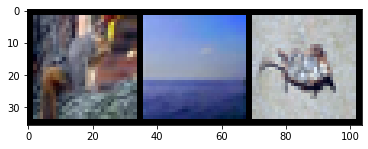

In [164]:
plt.imshow(transforms.ToPILImage()(pil_img))

In [165]:
pred, c1, c2, c3 = model(images.cuda())

In [166]:
torch.argmax(pred, dim=1)

tensor([80, 71, 74], device='cuda:0')

In [167]:
labels

tensor([80, 71, 74])

In [168]:
pred = pred.cpu()
torch.argmax(pred, dim=1).equal(labels)

True

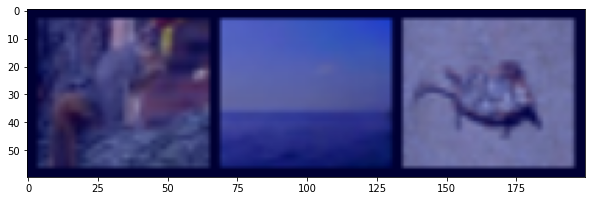

In [175]:
attn1 = visualize_attn_softmax(pil_img, c1, up_factor=1, nrow=6)
plt.figure(figsize=[10, 15])
plt.imshow(transforms.Resize((60, 200))(transforms.ToPILImage()(attn1)))

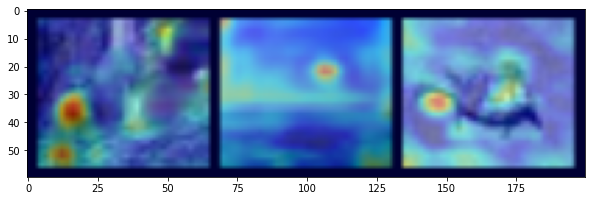

In [176]:
attn2 = visualize_attn_softmax(pil_img, c2, up_factor=2, nrow=6)
plt.figure(figsize=[10, 15])
plt.imshow(transforms.Resize((60, 200))(transforms.ToPILImage()(attn2)))

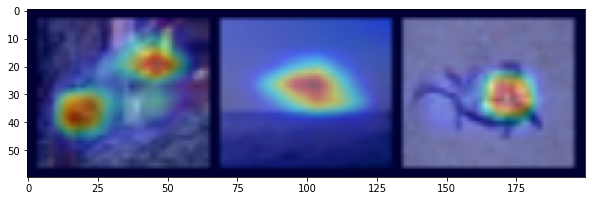

In [177]:
attn3 = visualize_attn_softmax(pil_img, c3, up_factor=4, nrow=6)
plt.figure(figsize=[10, 15])
plt.imshow(transforms.Resize((60, 200))(transforms.ToPILImage()(attn3)))

In [156]:
c1

tensor([[[[-4.9543e-05, -4.9556e-05, -4.9551e-05,  ..., -4.9554e-05,
           -4.9547e-05, -4.9547e-05],
          [-4.9558e-05, -4.9544e-05, -4.9561e-05,  ..., -4.9540e-05,
           -4.9559e-05, -4.9549e-05],
          [-4.9566e-05, -4.9556e-05, -4.9547e-05,  ..., -4.9549e-05,
           -4.9555e-05, -4.9559e-05],
          ...,
          [-4.9542e-05, -4.9544e-05, -4.9540e-05,  ..., -4.9551e-05,
           -4.9551e-05, -4.9552e-05],
          [-4.9539e-05, -4.9534e-05, -4.9534e-05,  ..., -4.9552e-05,
           -4.9546e-05, -4.9545e-05],
          [-4.9536e-05, -4.9542e-05, -4.9536e-05,  ..., -4.9545e-05,
           -4.9559e-05, -4.9539e-05]]],


        [[[-4.3998e-05, -4.4000e-05, -4.4004e-05,  ..., -4.3990e-05,
           -4.4002e-05, -4.3995e-05],
          [-4.3996e-05, -4.3999e-05, -4.4011e-05,  ..., -4.3995e-05,
           -4.4027e-05, -4.4010e-05],
          [-4.3989e-05, -4.4005e-05, -4.4002e-05,  ..., -4.4004e-05,
           -4.4002e-05, -4.4019e-05],
          ...,
   

In [129]:
c3

tensor([[[[ 4.5417,  7.8598,  8.4281,  8.6479,  6.9991,  5.3271,  3.9289,
            3.1473],
          [ 6.7859,  9.6879,  8.8542,  9.7309,  9.3430,  7.9268,  5.6685,
            4.4426],
          [ 6.1553,  9.7834, 10.0746, 11.4605, 10.8588,  9.0440,  7.5898,
            5.2477],
          [ 5.9849,  8.2751,  9.3762, 11.2984, 11.0882,  8.4668,  7.3141,
            5.2067],
          [ 6.5625,  9.5395,  9.4400, 11.1082, 11.1912,  8.7220,  7.8979,
            6.2297],
          [ 7.8144, 10.3677, 10.3252, 11.2099, 11.0858,  9.3166,  8.5970,
            7.3345],
          [ 6.8912,  9.5936,  9.1573, 10.1636, 10.6921,  9.6732,  9.6434,
            7.6598],
          [ 5.4428,  7.4894,  7.3375,  7.7979,  7.7578,  7.3007,  7.6964,
            6.1494]]],


        [[[ 3.7875,  5.2031,  5.4778,  6.2093,  7.2753,  8.5791,  9.4391,
            7.4340],
          [ 5.9042,  8.4552,  8.8320,  8.8443,  8.7893,  9.8948, 11.0017,
            8.3758],
          [ 7.8862, 11.6219, 11.5928, 11.0931,